In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../utils'))
#from ae_torch_classes import *
from data_loading_paths import *
from subspace_clustering_helper_funcs import *

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

## Loading in the data

In [5]:
num_rows_per_gesture = 64

# Maximum number of components
max_clusters = 12
num_clusters_range = list(range(2, max_clusters+1))

# Preprocessed (PPD) EMG

In [13]:
#from utils.data_loading_paths import *

kai_laptop = True
brc_desktop = False

if kai_laptop:
    data_path = kai_data_path
    model_dir_path = kai_model_dir_path
    metadata_path = kai_metadata_path
elif brc_desktop:
    data_path = brc_data_path
    model_dir_path = brc_model_dir_path
    metadata_path = brc_metadata_path

metadata_cols_df = pd.read_pickle(metadata_path)

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

full_emg_users_df = pd.concat([emg_training_users_df, emg_test_users_df])

In [14]:
print(full_emg_users_df.shape)
full_emg_users_df.head()

(204800, 16)


,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [18]:
print(metadata_cols_df.shape)
metadata_cols_df.head()

(204800, 3)


,Participant,Gesture_ID,Gesture_Num
0,P102,pan,1
1,P102,pan,1
2,P102,pan,1
3,P102,pan,1
4,P102,pan,1


In [ ]:
def run_supervised_clustering_algorithm(clustering_algo_str, X, metadata_cols_df, num_clusters=2, use_gesture_labels=True, use_user_labels=True, eps=0.5, min_samples=5):
    if clustering_algo_str == 'KMeans':
        model = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto') 
        # ^ Read about auto, basically controls how many times it is rerun
    elif clustering_algo_str == 'DBSCAN':
        #It's suitable for datasets with complex cluster shapes and noise.
        #However, it may struggle with clusters of varying densities or high-dimensional data.
        #--> Probably both are true for us?...
        model = DBSCAN(eps=eps, min_samples=min_samples)
    elif clustering_algo_str == 'OPTICS':
        #It's suitable for datasets with varying cluster densities and non-convex shapes.
        #It can handle noise and doesn't require specifying the number of clusters in advance.
        model = OPTICS(eps=eps, min_samples=min_samples)

    y_pred = model.fit_predict(X)

    label_encoder = LabelEncoder()
    ytrue_gestures = label_encoder.fit_transform(metadata_cols_df['Gesture_ID'].iloc[::num_rows_per_gesture])
    ytrue_users = label_encoder.fit_transform(metadata_cols_df['Participant'].iloc[::num_rows_per_gesture])

    #print(f"X.shape: {X.shape}")
    #print(f"ytrue_gestures.shape: {ytrue_gestures.shape}")
    #print(f"ytrue_users.shape: {ytrue_users.shape}")

    # Compute clustering metrics
    silhouette = silhouette_score(X, y_pred)
    #db_index = davies_bouldin_score(X, y_pred)
    #ch_index = calinski_harabasz_score(X, y_pred)
    #di_index = dunn_index(X, y_pred)
    #gap_stat = gap_statistics(X, y_pred)
    if use_gesture_labels:
        gesture_adjmutinfosc = adjusted_mutual_info_score(ytrue_gestures, y_pred)
        gesture_adjrandsc = adjusted_rand_score(ytrue_gestures, y_pred)
        gesture_pairconfmat = pair_confusion_matrix(ytrue_gestures, y_pred)
        gesture_homcomv = homogeneity_completeness_v_measure(ytrue_gestures, y_pred)
    else:
        gesture_adjmutinfosc, gesture_adjrandsc, gesture_pairconfmat, gesture_homcomv = None, None, None, None
        
    if use_user_labels:
        user_adjmutinfosc = adjusted_mutual_info_score(ytrue_users, y_pred)
        user_adjrandsc = adjusted_rand_score(ytrue_users, y_pred)
        user_pairconfmat = pair_confusion_matrix(ytrue_users, y_pred)
        user_homcomv = homogeneity_completeness_v_measure(ytrue_users, y_pred)
    else:
        user_adjmutinfosc, user_adjrandsc, user_pairconfmat, user_homcomv = None, None, None, None

    return silhouette, [gesture_adjmutinfosc, gesture_adjrandsc, gesture_pairconfmat, gesture_homcomv], [user_adjmutinfosc, user_adjrandsc, user_pairconfmat, user_homcomv]

## Testing on Standardized EMG

In [36]:
num_gestures = len(full_emg_users_df) // num_rows_per_gesture
num_features = full_emg_users_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(full_emg_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
full_emg_2D_npy = full_emg_users_df.to_numpy().reshape(num_gestures, num_rows_per_gesture*num_features)
#flattened_full_emg_data = full_emg_2D_npy.reshape(-1, 1)

In [37]:
full_emg_2D_npy.shape

(3200, 1024)

In [35]:
metadata_cols_df.iloc[::num_rows_per_gesture].shape

(3200, 3)

In [20]:
#from sklearn.cluster import HDBSCAN
#hdb = HDBSCAN(min_cluster_size=20)
#hdb.fit(X)
#hdb.labels_

In [43]:
stdemg_silhouette_lst=[]
stdemg_gesture_lst=[]
stdemg_user_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, gesture_res, user_res = run_supervised_clustering_algorithm('KMeans', full_emg_2D_npy, metadata_cols_df, num_clusters=n)
    stdemg_silhouette_lst.append(silhouette)
    stdemg_gesture_lst.extend(gesture_res)
    stdemg_user_lst.extend(user_res)

2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


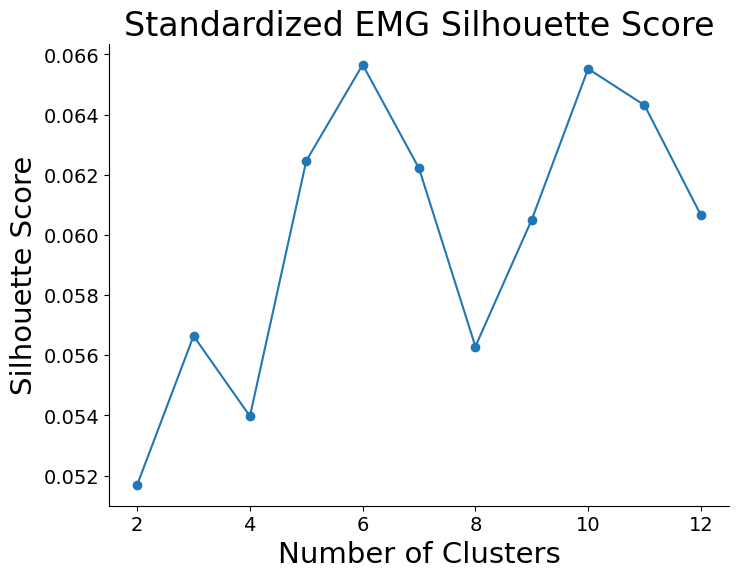

In [49]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, stdemg_silhouette_lst, marker='o')

ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    label.set_verticalalignment('top')
    # ValueError: 'left' is not a valid value for align; supported values are 'top', 'bottom', 'center', 'baseline', 'center_baseline'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Standardized EMG Silhouette Score', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Silhouette Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()

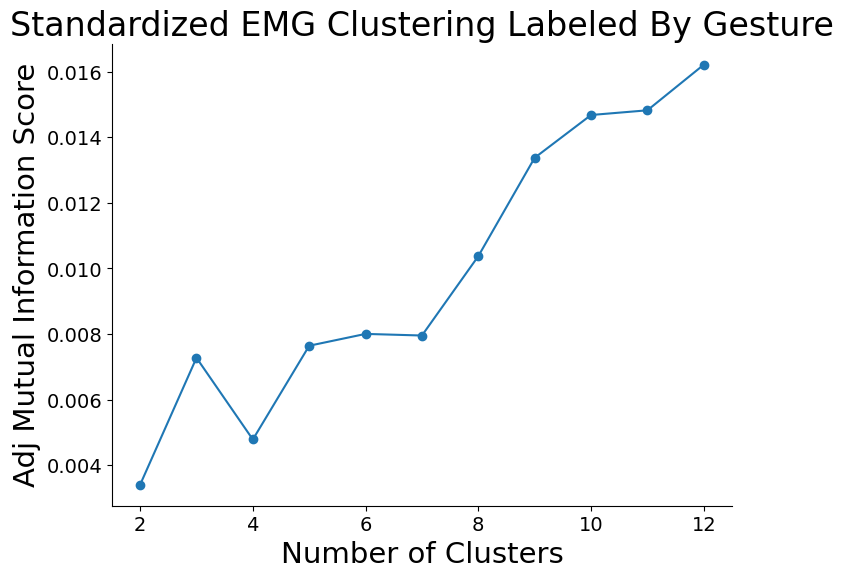

In [56]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, stdemg_gesture_lst[::4], marker='o')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Standardized EMG Clustering Labeled By Gesture', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Adj Mutual Information Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()

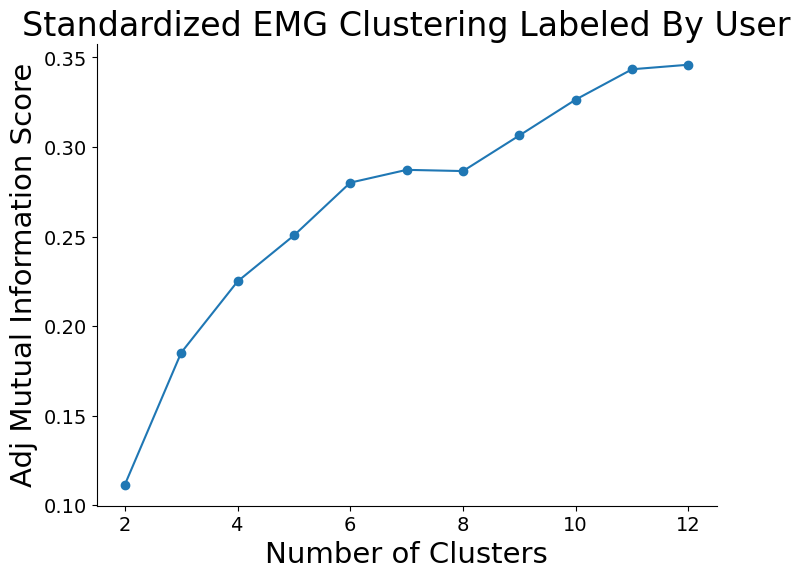

In [57]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, stdemg_user_lst[::4], marker='o')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Standardized EMG Clustering Labeled By User', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Adj Mutual Information Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()

## PCA 8

In [58]:
pca = PCA(n_components=8)
pca_df = pd.DataFrame(data=pca.fit_transform(full_emg_users_df), columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
#pca_df = pd.concat([metadata_cols_df, pca_df], axis=1)

print(pca_df.shape)
pca_df.head()


(204800, 8)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.341323,-0.812209,0.089633,-0.231389,-1.102774,-0.123494,-0.452216,-0.563469
1,-0.644262,-0.860011,0.240803,-0.036121,-1.728382,-0.271787,-1.100263,0.143207
2,-1.251829,-0.823973,-0.213519,0.139521,-2.368628,-0.276726,-2.114243,0.468320
3,-1.494897,-0.633561,-0.233368,0.250943,-2.434067,-0.437012,-2.570415,0.370891
4,1.615750,-1.806795,-1.070433,-0.332640,-2.581807,-0.507581,-3.102347,0.600151


Let's actually re-arrange to make them 3D matrices...

In [60]:
num_gestures = len(pca_df) // num_rows_per_gesture
num_features = pca_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(pca_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
data_np = pca_df.to_numpy()
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
emg_PCA8_npy = data_np.reshape(num_gestures, num_rows_per_gesture*num_features)

print(emg_PCA8_npy.shape)

(3200, 512)


In [61]:
pca8emg_silhouette_lst=[]
pca8emg_gesture_lst=[]
pca8emg_user_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, gesture_res, user_res = run_supervised_clustering_algorithm('KMeans', emg_PCA8_npy, metadata_cols_df, num_clusters=n)
    pca8emg_silhouette_lst.append(silhouette)
    pca8emg_gesture_lst.extend(gesture_res)
    pca8emg_user_lst.extend(user_res)

2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


In [76]:
pca8emg_gesture_lst[:4]

[0.0034771888496863365,
 0.001463568226488039,
 array([[3788472, 5427528],
        [ 414870,  605930]], dtype=int64),
 (0.0028021577889560507, 0.010740311423820889, 0.004444691265560135)]

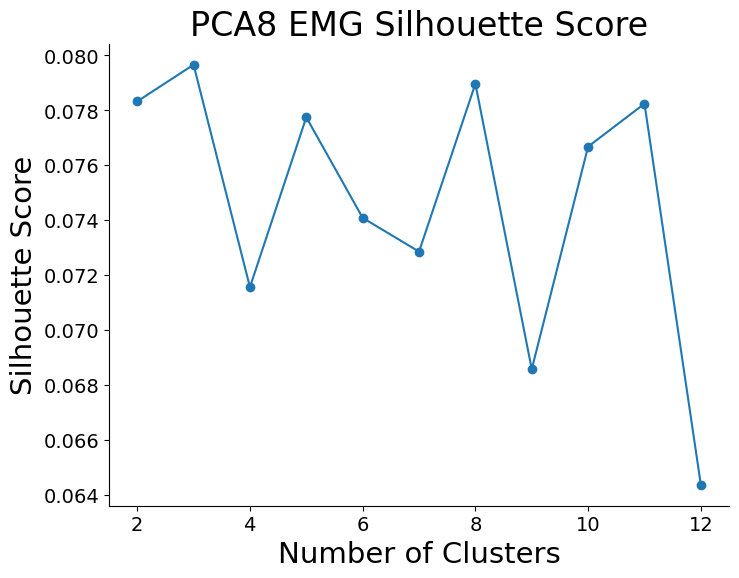

In [62]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, pca8emg_silhouette_lst, marker='o')

ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    label.set_verticalalignment('top')
    # ValueError: 'left' is not a valid value for align; supported values are 'top', 'bottom', 'center', 'baseline', 'center_baseline'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('PCA8 EMG Silhouette Score', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Silhouette Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()

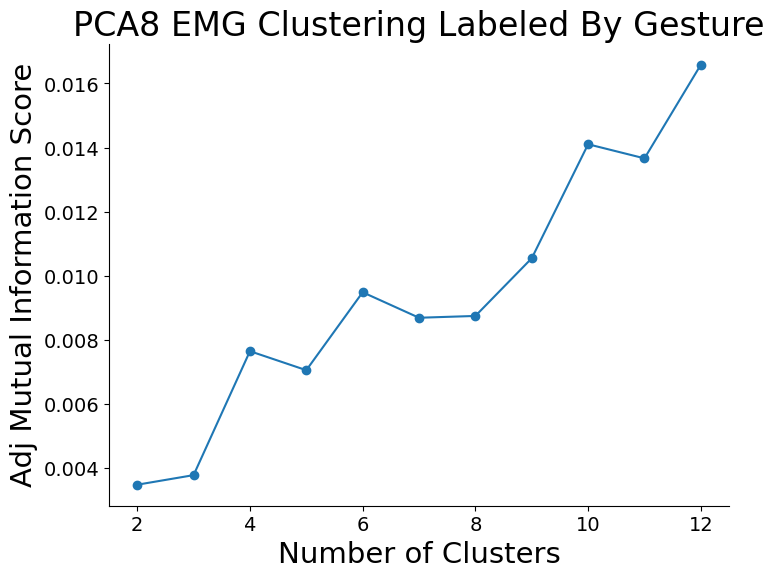

In [63]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, pca8emg_gesture_lst[::4], marker='o')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('PCA8 EMG Clustering Labeled By Gesture', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Adj Mutual Information Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()

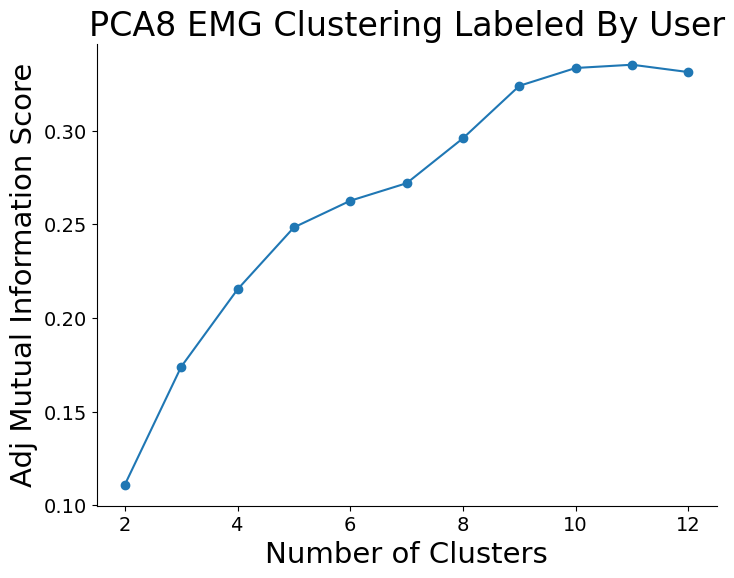

In [64]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, pca8emg_user_lst[::4], marker='o')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('PCA8 EMG Clustering Labeled By User', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Adj Mutual Information Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()

## PCA 3

In [67]:
pca = PCA(n_components=3)
pca_df = pd.DataFrame(data=pca.fit_transform(full_emg_users_df), columns=['PC1', 'PC2', 'PC3'])
#pca_df = pd.concat([metadata_cols_df, pca_df], axis=1)

print(pca_df.shape)
pca_df.head()


(204800, 3)


,PC1,PC2,PC3
0,-1.341324,-0.812214,0.089626
1,-0.644263,-0.860014,0.240799
2,-1.251831,-0.823985,-0.213534
3,-1.494900,-0.633582,-0.233395
4,1.615747,-1.806816,-1.070459


In [68]:
num_gestures = len(pca_df) // num_rows_per_gesture
num_features = pca_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(pca_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
data_np = pca_df.to_numpy()
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
emg_PCA3_npy = data_np.reshape(num_gestures, num_rows_per_gesture*num_features)

print(emg_PCA3_npy.shape)

(3200, 192)


In [69]:
pca3emg_silhouette_lst=[]
pca3emg_gesture_lst=[]
pca3emg_user_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, gesture_res, user_res = run_supervised_clustering_algorithm('KMeans', emg_PCA3_npy, metadata_cols_df, num_clusters=n)
    pca3emg_silhouette_lst.append(silhouette)
    pca3emg_gesture_lst.extend(gesture_res)
    pca3emg_user_lst.extend(user_res)

2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


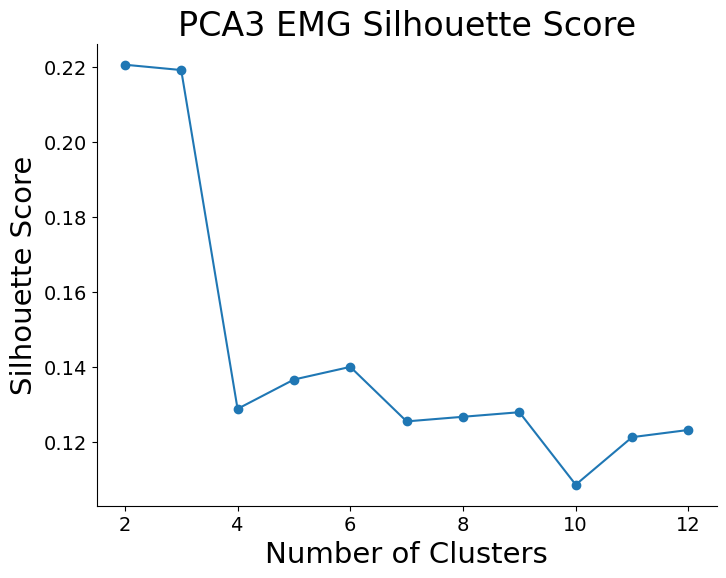

In [70]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, pca3emg_silhouette_lst, marker='o')

ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    label.set_verticalalignment('top')
    # ValueError: 'left' is not a valid value for align; supported values are 'top', 'bottom', 'center', 'baseline', 'center_baseline'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('PCA3 EMG Silhouette Score', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Silhouette Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()

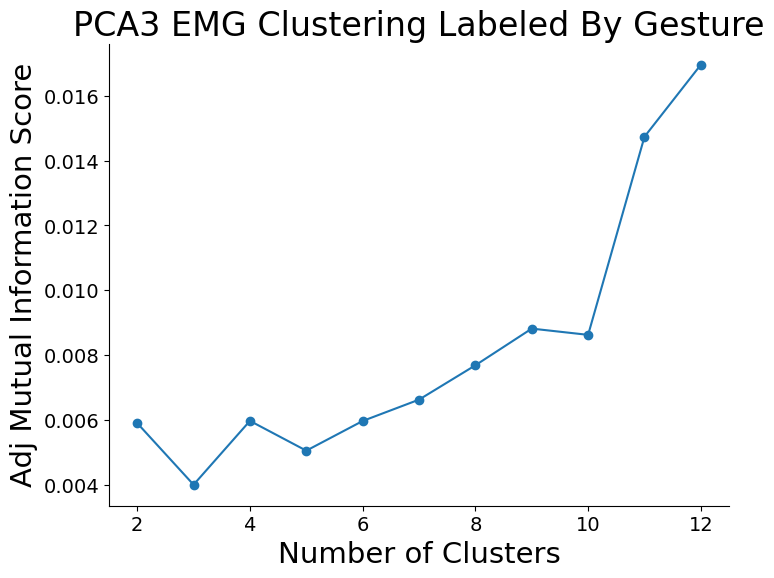

In [71]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, pca3emg_gesture_lst[::4], marker='o')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('PCA3 EMG Clustering Labeled By Gesture', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Adj Mutual Information Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()

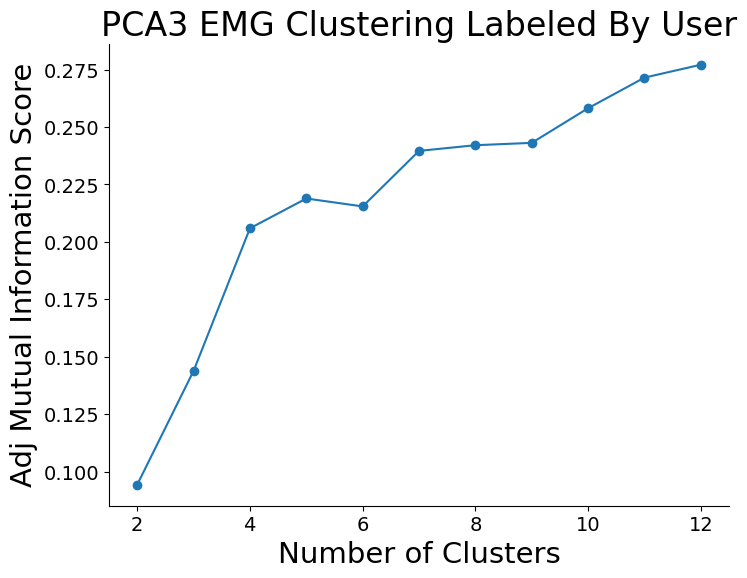

In [72]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, pca3emg_user_lst[::4], marker='o')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('PCA3 EMG Clustering Labeled By User', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Adj Mutual Information Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)

plt.show()

# COMBINED PLOTS

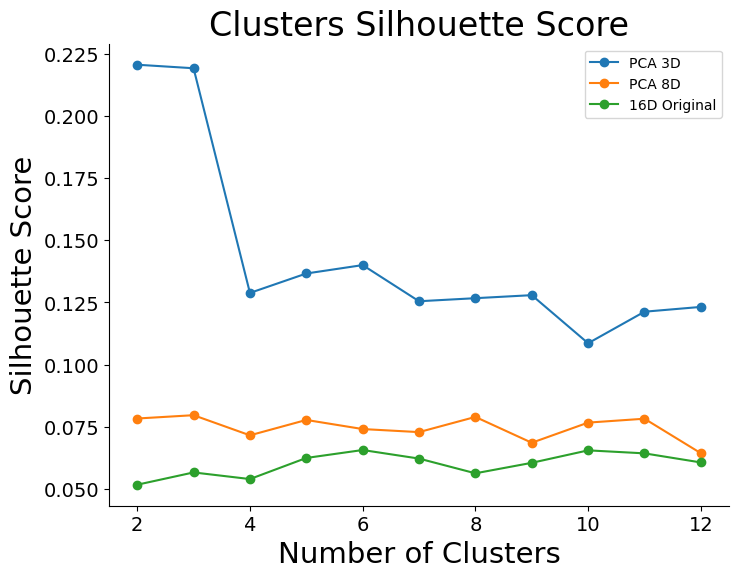

In [77]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, pca3emg_silhouette_lst, marker='o', label='PCA 3D')
plt.plot(num_clusters_range, pca8emg_silhouette_lst, marker='o', label='PCA 8D')
plt.plot(num_clusters_range, stdemg_silhouette_lst, marker='o', label='16D Original')

ax = plt.gca()
x_labels = ax.get_xmajorticklabels()
for label in x_labels:
    label.set_verticalalignment('top')
    # ValueError: 'left' is not a valid value for align; supported values are 'top', 'bottom', 'center', 'baseline', 'center_baseline'
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Clusters Silhouette Score', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Silhouette Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)
plt.legend()

plt.show()

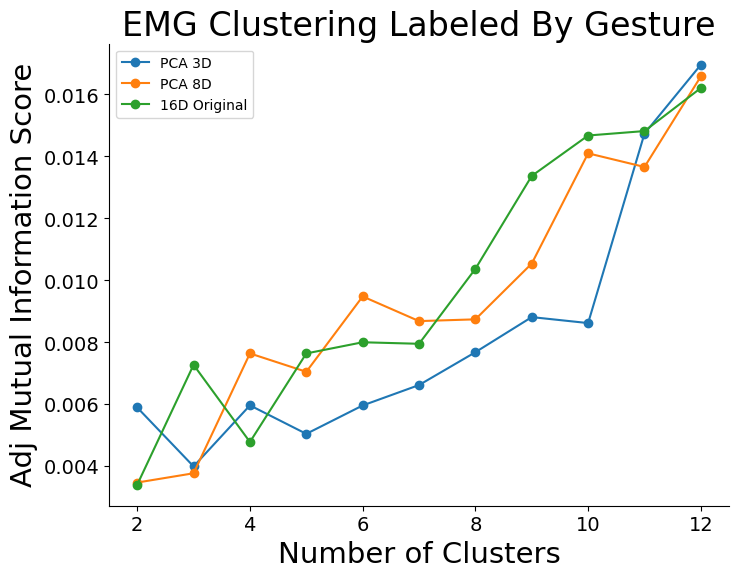

In [74]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, pca3emg_gesture_lst[::4], marker='o', label='PCA 3D')
plt.plot(num_clusters_range, pca8emg_gesture_lst[::4], marker='o', label='PCA 8D')
plt.plot(num_clusters_range, stdemg_gesture_lst[::4], marker='o', label='16D Original')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('EMG Clustering Labeled By Gesture', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Adj Mutual Information Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)
plt.legend()

plt.show()

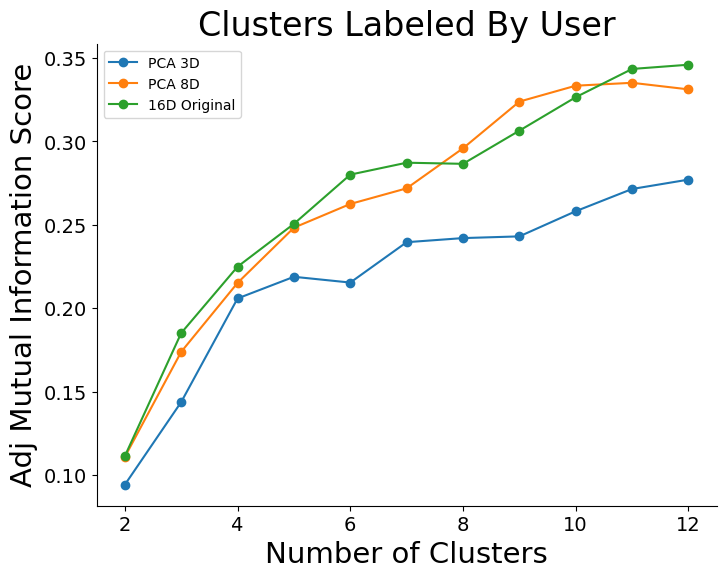

In [78]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, pca3emg_user_lst[::4], marker='o', label='PCA 3D')
plt.plot(num_clusters_range, pca8emg_user_lst[::4], marker='o', label='PCA 8D')
plt.plot(num_clusters_range, stdemg_user_lst[::4], marker='o', label='16D Original')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Clusters Labeled By User', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Adj Mutual Information Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)
plt.legend()

plt.show()

In [81]:
np.array(pca3emg_user_lst[1::4]) - np.array(pca3emg_user_lst[::4])

array([-0.08175841, -0.12290553, -0.15982799, -0.16816858, -0.16626872,
       -0.18246618, -0.18364153, -0.18305604, -0.18935484, -0.20093305,
       -0.20629288])

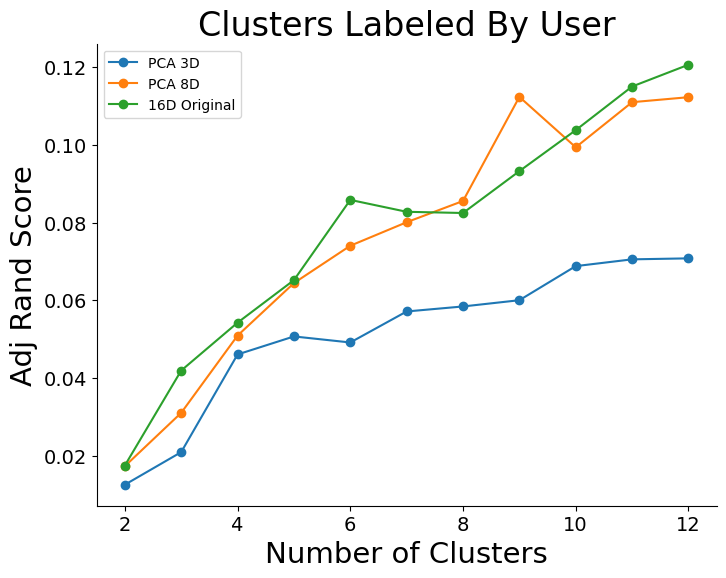

In [82]:
# Plot the silhouette scores

plt.figure(figsize=(8, 6))

plt.plot(num_clusters_range, pca3emg_user_lst[1::4], marker='o', label='PCA 3D')
plt.plot(num_clusters_range, pca8emg_user_lst[1::4], marker='o', label='PCA 8D')
plt.plot(num_clusters_range, stdemg_user_lst[1::4], marker='o', label='16D Original')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

title_font = 24
label_font = 21
tick_font = 14

plt.title('Clusters Labeled By User', fontsize=title_font)
plt.xlabel('Number of Clusters', fontsize=label_font)
plt.ylabel('Adj Rand Score', fontsize=label_font)
plt.xticks(fontsize=tick_font)
plt.yticks(fontsize=tick_font)
plt.legend()

plt.show()

## EMG Only: PCA 3D

In [7]:
print("Loading")
start_time = time.time()

data_path = base_path + "EMG_PCA3\\"

# Dropping the metadata when we read it in!
emg3_training_u_df = pd.read_pickle(data_path+'emg_PCA3_training_u_df.pkl').drop(metadata_cols, axis=1)
emg3_test_users_df = pd.read_pickle(data_path+'emg_PCA3_test_users_df.pkl').drop(metadata_cols, axis=1)

end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 0.23379015922546387s


In [8]:
print(emg3_training_u_df.shape)
emg3_training_u_df.head()

(327168, 3)


,0,1,2
0,-0.027903,0.001411,-0.019509
1,-0.038982,0.006470,-0.000111
2,-0.116782,0.003824,0.011550
3,-0.030245,-0.017409,0.022540
4,-0.112950,0.026262,0.004837


In [9]:
print(emg3_test_users_df.shape)
emg3_test_users_df.head()

(99584, 3)


,0,1,2
11520,0.068817,0.042105,-0.044102
11521,0.074061,0.047283,-0.042408
11522,0.079972,0.043184,-0.055275
11523,0.066582,0.035923,-0.040610
11524,0.070243,0.048672,-0.050055


In [10]:
num_gestures = len(emg3_training_u_df) // num_rows_per_gesture
num_features = emg3_training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(emg3_training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
emg3_PCA_np = emg3_training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
emg3_flattened_PCA = emg3_PCA_np.reshape(num_gestures, -1)

In [45]:
km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', emg3_flattened_PCA, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    #km_davies_bouldin_lst.append(db_index)
    #km_cali_har_lst.append(ch_index)
    #km_dunn_index_lst.append(di_index)
    #km_gap_stat_lst.append(gap_stat)

2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


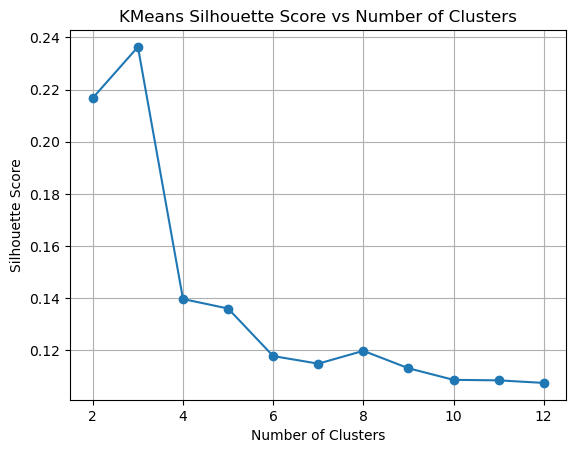

In [46]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_silhouette_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()